# **Zipline Reloaded를 활용한 이벤트 기반 팩터 포트폴리오 백테스팅**

Zipline Reloaded는 시장 이벤트를 순차적으로 처리하는 이벤트 기반 백테스팅 프레임워크로, 주문 체결과 슬리피지를 보다 현실적으로 모델링할 수 있게 합니다. 벡터 기반 프레임워크와 달리 시장 이벤트의 시간적 순서를 고려하므로, 조건부 주문이나 자산 상호 작용 등 복잡한 전략에 적합합니다. 일반적으로 벡터 기반 접근 방식보다 속도는 느리지만, 이벤트 기반 백테스팅 프레임워크는 복잡한 주문 로직, 상태 관리, 리스크 관리를 필요로 하는 경로 의존적(Path-Dependent) 전략에 더 적합한 시장 동학을 시뮬레이션할 수 있습니다.

Zipline Reloaded는 대규모 종목(large universes)과 복잡한 포트폴리오 구성 기법을 백테스팅하기에 탁월합니다. Pipeline API는 수천 개의 종목에 대해 팩터를 고효율로 계산하도록 설계되었습니다. 이 장에서는 Zipline Reloaded를 활용해 포트폴리오 팩터 전략을 백테스팅하고, 결과를 Zipline Reloaded 에코시스템 내의 다른 도구로 분석해 볼 것입니다.

본 장에서는 다음과 같은 예시(레시피)를 다룹니다:

- Zipline Reloaded로 모멘텀 팩터 전략 백테스팅
- Zipline Reloaded로 평균 회귀(mean reversion) 전략 탐색

---

## Technical Requirements

Zipline Reloaded는 **Chapter 5, _Build Alpha Factors for Stock Portfolios_** 에서 설치했습니다. 혹시 놓쳤다면, 여기에서 안내하는 방법을 따라 설치하세요. 운영 체제에 따라 Zipline Reloaded를 설치하는 단계가 달라집니다.

---

### For Windows, Unix/Linux, and Mac Intel users

인텔 x86 칩을 사용하는 경우, 다음과 같이 **conda**를 이용해 설치할 수 있습니다:

```
conda install -c conda-forge zipline-reloaded pyfolio-reloaded alphalens-reloaded -y
```

---

### For Mac M1/M2 users

M1 또는 M2 칩을 탑재한 Mac을 사용 중이라면, 먼저 몇 가지 종속성(dependencies)을 설치해야 합니다. 가장 쉬운 방법은 [Homebrew](https://brew.sh)를 사용하는 것입니다.

**Homebrew로 종속성 설치**:
```
brew install freetype pkg-config gcc openssl hdf5 ta-lib
```

**conda로 Python 종속성 설치**:
```
conda install -c conda-forge pytables h5py -y
```

**Zipline Reloaded 에코시스템 설치**:
```
pip install zipline-reloaded pyfolio-reloaded alphalens-reloaded
```

---

## Zipline Reloaded로 모멘텀 팩터 전략 백테스팅하기
 
시작하기 전에, 벡터 기반 백테스팅 프레임워크와 이벤트 기반 백테스팅 프레임워크의 차이점을 이해하는 것이 중요합니다. 6장 'VectorBT를 이용한 벡터 기반 백테스팅'에서 벡터 기반과 이벤트 기반 백테스팅의 차이점을 다룬 바 있습니다.

다음은 좀 더 상세한 평가 내용입니다:

| **항목(Feature)**               | **벡터 기반(Vector-Based)**                                                           | **이벤트 기반(Event-Based)**                                                                              |
|---------------------------------|-------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------|
| **처리 방식** (Processing Method)             | 벡터화된 연산 (Vectorized operations)                                                                          | 순차적 처리 (Sequentially)                                                                                 |
| **계산 효율성** (Computational Efficiency)      | 대규모 데이터셋에 대해 매우 효율적 (Highly efficient, especially for large datasets)                                 | 각 이벤트를 개별적으로 처리해야 하므로 효율이 떨어짐 (Less efficient due to the need to process each event individually) |
| **코딩 복잡성** (Complexity in Coding)          | 더 간단하고 간결함 (Simpler and more concise)                                                                     | 시장 이벤트를 보다 정확히 시뮬레이션하기 위해 세부적인 프로그래밍 필요 (More detailed programming to simulate market events accurately) |
| **전략 유형 적합성** (Suitability for Strategy Type) | 복잡한 상태(state)나 경로 의존성(path dependencies) 없는 전략에 적합 (Without complex state or path dependencies.)      | 복잡하고 상태 의존적이며 경로 의존적인 전략에 이상적 (Ideal for complex, state-dependent, and path-dependent strategies) |
| **주문 체결 모델링** (Order Execution Modeling)   | 주문이 즉시 체결된다고 가정하므로, 슬리피지(slippage)나 지연(delays) 등 실제 시장 상황을 모델링하는 데는 부정확 (Assumes immediate order execution; less accurate for modeling real market conditions like slippage and delays.) | 지연, 슬리피지, 부분 체결(partial fills) 등을 포함해 주문 체결 동학을 보다 정확히 모델링 (More accurately models order execution dynamics, including delays, slippage, and partial fills) |
| **리스크 관리 시뮬레이션** (Risk Management Simulation) | 기본적인 리스크 관리 기능만 제공하므로, 동적 리스크 조정을 충분히 반영하지 못할 수 있음 (Basic risk management features; may not capture dynamic risk adjustments effectively.) | 스톱로스(stop-losses) 등 현실적인 실시간 조정을 포함한 정교한 리스크 관리 시뮬레이션 (Detailed risk management with realistic simulations of stop-losses and other real-time adjustments.) |
| **확장성** (Scalability)             | 대규모 데이터 분석 및 다중 자산에 대해 높은 확장성 보유 (Highly scalable for large-scale data analysis and multiple assets.)     | 틱 단위(tick-by-tick) 대규모 데이터 처리 시 계산 요구량이 많아 어려움 (Challenging with large-scale tick-by-tick data due to computational demands.) |
| **과적합 위험** (Risk of Overfitting)          | 과적합 위험이 더 높음 (Higher risk of overfitting)                                                               | 위험은 존재하지만 더 효과적으로 관리 가능 (Risk exists but can be better managed)                                                |
| **개발 주기** (Development Cycle)          | 계산 효율성과 단순한 코드로 인해 빠른 개발 및 테스트 가능 (Faster development and testing cycles due to computational efficiency and simpler code.) | 복잡성과 계산 부하 증가로 인해 상대적으로 느릴 수 있음 (Potentially slower due to increased complexity and computational demands)               |
| **현실성** (Realism)                | 시장 이벤트가 순차적으로 흐르는 과정을 시뮬레이션하지 않아 현실감이 떨어짐 (Less realistic as it does not simulate the sequential flow of market events.) | 실제 시장 상황과 트레이더 행동을 보다 현실감 있게 시뮬레이션 (Higher realism in simulating real-world market conditions and trader actions.)       |

그림 8.1: 벡터 기반과 이벤트 기반 백테스팅 프레임워크 비교

5장 '주식 포트폴리오를 위한 알파 팩터 구축'에서 우리는 252일 기간 동안 미국 주식의 모멘텀 점수를 계산하는 커스텀 팩터를 정의했습니다. 이 팩터의 값은 252일 상대 가격 변화와 22일 상대 가격 변화를 비교하여 결정됩니다. 이 차이는 126일 수익률의 표준편차로 나누어 표준화되며, 이는 자산의 최근 변동성으로 모멘텀 점수를 효과적으로 조정합니다. 그 결과 각 자산에 대해 정규화된 모멘텀 점수가 제공되며, 이는 최근 변동성과 관련하여 장기 및 단기 가격 움직임을 모두 포착합니다.

이번 예제에서는 이 팩터를 Zipline Reloaded 백테스팅 프레임워크에 통합하고 전략의 성과를 검토해보겠습니다.

---

### **준비하기**

우리는 여러분이 무료로 제공되는 Quandl 데이터 번들을 이미 로컬 머신에 저장했고 이를 불러올 수 있다고 가정합니다. 또한, 환경 변수에 Nasdaq API 키가 여전히 설정되어 있다고 가정합니다. 만약 그렇지 않다면, 다음 코드를 import 이후 실행하세요:

````python
from zipline.data.bundles.core import load
os.environ["QUANDL_API_KEY"] = "YOUR_API_KEY"
bundle_data = load("quandl", os.environ, None)
````

무료 데이터는 약 3,000개의 미국 주식으로 제한되며, 데이터 수집은 2018년까지만 가능합니다. 매일 업데이트되는 약 20,000개의 미국 주식 데이터를 포함한 데이터 커버리지가 필요하다면, Nasdaq에서 제공하는 프리미엄 데이터 서비스를 고려해볼 수 있습니다.  

프리미엄 데이터를 설정하는 방법은 다음 URL에서 확인할 수 있습니다:  
[How to ingest premium market data with Zipline Reloaded](https://www.pyquantnews.com/free-python-resources/how-to-ingest-premium-market-data-with-zipline-reloaded)  

이 프리미엄 데이터를 사용하는 경우, 아래의 `quandl`을 코드의 `quandlmedia`로 교체하세요.

---

### **실행 방법...**

이 레시피에서는 Zipline Reloaded 백테스팅 프레임워크의 새로운 기능을 소개합니다. 여기에는 날짜 및 시간 규칙, Pipeline API, 사용자 지정 팩터(custom factors), 커미션 및 슬리피지 모델이 포함됩니다.

```python
!pip install logbook
```

1. 백테스트에 필요한 라이브러리를 먼저 import합니다:

In [1]:
import warnings

In [2]:
# 기본 데이터 분석 및 처리를 위한 라이브러리
import numpy as np  # 수치 연산을 위한 라이브러리
import pandas as pd  # 데이터 분석을 위한 라이브러리
import pandas_datareader as web  # 금융 데이터 수집을 위한 라이브러리

# IPython 디스플레이 관련 라이브러리
from IPython.display import Markdown, display

# Zipline 관련 라이브러리
from zipline import run_algorithm  # 알고리즘 실행을 위한 메인 함수

# Zipline API 함수들
from zipline.api import (
    attach_pipeline,     # 파이프라인 연결
    calendars,          # 거래일 캘린더
    date_rules,         # 날짜 규칙
    get_open_orders,    # 미체결 주문 조회
    order_target_percent,  # 목표 비중으로 주문
    pipeline_output,    # 파이프라인 결과 출력
    record,            # 기록
    schedule_function,  # 함수 스케줄링
    set_commission,    # 수수료 설정
    set_slippage,      # 슬리피지 설정
    time_rules,        # 시간 규칙
)

# Zipline 파이프라인 관련 라이브러리
from zipline.pipeline import Pipeline  # 파이프라인 클래스
from zipline.pipeline.data import USEquityPricing  # 미국 주식 가격 데이터
from zipline.pipeline.factors import AverageDollarVolume, CustomFactor, Returns  # 팩터 관련 클래스들

In [3]:
warnings.filterwarnings("ignore")

2. 포트폴리오에서 롱(long) 및 숏(short) 종목 수를 정의합니다:

In [4]:
N_LONGS = N_SHORTS = 50

3. 이전 장에서 정의한 사용자 지정 모멘텀 팩터(custom momentum factor)를 사용합니다:

사용자 지정 모멘텀 팩터 정의

In [5]:
class MomentumFactor(CustomFactor):
    # 입력값: 종가와 126일 수익률
    inputs = [USEquityPricing.close, Returns(window_length=126)]
    # 252일(1년) 데이터 사용
    window_length = 252

    def compute(self, today, assets, out, prices, returns):
        # 모멘텀 계산:
        # 1. 1년 수익률 (252일 전 대비)에서 
        # 2. 1달 수익률 (21일 전 대비)을 뺀 후
        # 3. 수익률의 표준편차로 나누어 표준화
        out[:] = (
            (prices[-21] - prices[-252]) / prices[-252]  # 1년 수익률
            - (prices[-1] - prices[-21]) / prices[-21]   # 1달 수익률
        ) / np.nanstd(returns, axis=0)                   # 표준화

4. 이전 장에서 정의한 동일한 Pipeline을 사용합니다:

팩터와 종목 선택을 위한 파이프라인 정의

In [6]:
def make_pipeline():
    # 모멘텀 팩터 인스턴스 생성
    momentum = MomentumFactor()
    # 30일 평균 거래대금 팩터 생성
    dollar_volume = AverageDollarVolume(window_length=30)
    
    # 파이프라인 생성 및 반환
    return Pipeline(
        columns={
            "factor": momentum,              # 모멘텀 팩터 값
            "longs": momentum.top(N_LONGS),  # 상위 N_LONGS개 종목
            "shorts": momentum.bottom(N_SHORTS), # 하위 N_SHORTS개 종목  
            "ranking": momentum.rank(),      # 모멘텀 순위
        },
        # 거래대금 상위 100개 종목으로 필터링
        screen=dollar_volume.top(100),
    )

5. Zipline Reloaded는 이벤트 기반 백테스팅 프레임워크로, 거래 시작 전 발생하는 이벤트를 포함해 다양한 이벤트에 "훅(hook)"을 걸 수 있습니다. 
이 훅을 사용해 팩터 파이프라인을 "설치"합니다:

거래 시작 전에 호출될 함수를 정의합니다

In [7]:
def before_trading_start(context, data):
    # 매일 거래 시작 전에 팩터 파이프라인의 결과를 가져와서 context에 저장
    context.factor_data = pipeline_output("factor_pipeline")

6. 다음으로, 백테스트가 시작될 때 실행되는 `initialize` 함수를 정의합니다:

알고리즘을 설정하는 initialize 함수를 정의합니다

In [8]:
def initialize(context):
    # 팩터 파이프라인을 연결
    attach_pipeline(make_pipeline(), "factor_pipeline")
    
    # 매주 시작일 장 시작 시점에 리밸런싱 함수 실행 스케줄링
    schedule_function(
        rebalance,  # 실행할 함수
        date_rules.week_start(),  # 매주 시작일에 실행
        time_rules.market_open(), # 장 시작 시점에 실행
        calendar=calendars.US_EQUITIES,  # 미국 주식 시장 캘린더 사용
    )

7. 이제 포트폴리오를 리밸런싱하는 논리를 포함하는 `rebalance` 함수를 정의합니다. 여기에서는 가장 높은 순위의 팩터를 가진 상위 `N_LONGS` 종목을 매수하고, 가장 낮은 순위의 팩터를 가진 하위 `N_SHORTS` 종목을 공매도합니다:

거래를 실행하는 리밸런싱 함수를 정의합니다

In [9]:
def rebalance(context, data):
    # 팩터 데이터 가져오기
    factor_data = context.factor_data
    # 팩터 랭킹 기록
    record(factor_data=factor_data.ranking)

    # 전체 자산 목록 가져오기
    assets = factor_data.index
    # 현재 가격 기록
    record(prices=data.current(assets, "price"))

    # 롱 포지션과 숏 포지션 자산 필터링
    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    # 청산할 포지션 계산 (현재 보유 중이나 롱/숏 목록에 없는 자산)
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))

    # 청산할 포지션 매도 (목표 비중 0%)
    exec_trades(data, assets=divest, target_percent=0)
    # 롱 포지션 매수 (각 종목 동일 비중)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)
    # 숏 포지션 매도 (각 종목 동일 비중)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS)

8. 주문 실행 논리를 `exec_trades` 함수로 추상화합니다. 이 함수는 제공된 자산을 반복하며 주문을 실행합니다:

거래를 실행하는 함수 정의

In [10]:
def exec_trades(data, assets, target_percent):
    # 각 자산에 대해 반복
    for asset in assets:
        # 해당 자산이 거래 가능하고 미체결 주문이 없는 경우
        if data.can_trade(asset) and not get_open_orders(asset):
            # 목표 비중으로 주문 실행
            order_target_percent(asset, target_percent)

성과를 시각화하는 분석 함수를 정의합니다

In [11]:
def analyze(context, perf):
    perf.portfolio_value.plot()

백테스트의 시작일과 종료일을 정의합니다

In [12]:
start = pd.Timestamp("2016")
end = pd.Timestamp("2018")

벤치마크 수익률(S&P 500) 가져오기

In [13]:
sp500 = web.DataReader("SP500", "fred", start, end).SP500
benchmark_returns = sp500.pct_change()

9. 마지막으로, `run_algorithm` 함수를 사용해 백테스트를 실행합니다:

알고리즘 실행

In [14]:
# run_algorithm 함수를 사용하여 백테스트 실행
# start: 백테스트 시작일
# end: 백테스트 종료일  
# initialize: 초기 설정 함수
# before_trading_start: 매 거래일 시작 전 실행되는 함수
# capital_base: 초기 투자금액 (10만 달러)
# benchmark_returns: 벤치마크(S&P 500) 수익률
# bundle: 사용할 데이터 번들
perf = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    before_trading_start=before_trading_start,
    capital_base=100_000,
    benchmark_returns=benchmark_returns,
    bundle="quandl",
)

출력은 백테스트의 각 날에 대한 거래, 리스크, 성과 통계가 포함된 `DataFrame`입니다.  

성과 정보 표시

In [15]:
display(perf.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2016-01-04 21:00:00+00:00 to 2017-12-29 21:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              503 non-null    datetime64[ns, UTC]
 1   period_close             503 non-null    datetime64[ns, UTC]
 2   ending_cash              503 non-null    float64            
 3   gross_leverage           503 non-null    float64            
 4   short_exposure           503 non-null    float64            
 5   pnl                      503 non-null    float64            
 6   shorts_count             503 non-null    int64              
 7   long_value               503 non-null    float64            
 8   short_value              503 non-null    float64            
 9   starting_cash            503 non-null    float64            
 10  capital_used             503 non-null    float64 

None

이 `DataFrame`을 사용해 백테스트의 특성을 분석합니다.

### 작동 방식...

우리는 **Chapter 5, Build Alpha Factors for Stock Portfolios**에서 설명한 **Pipeline API** 및 사용자 정의 팩터의 작동 원리를 다룹니다. 여기서는 백테스트를 실행하는 나머지 코드를 중점적으로 설명합니다. **before_trading_start** 함수는 매 거래일 시작 전에 호출되며, 다음 두 가지 매개변수를 사용합니다:

- **context**: 함수 호출 간 변수 저장을 허용하는 지속 가능한 네임스페이스입니다. 여러 날 동안 값을 유지할 수 있으며 알고리즘이 필요로 하는 데이터를 관리하는 데 사용됩니다.
- **data**: 현재 및 과거 가격 및 거래량 데이터 등에 대한 액세스를 제공합니다.

매 거래일 전, **factor_pipeline**이라는 정의된 파이프라인의 출력을 가져옵니다. **pipeline_output** 함수는 해당 파이프라인의 계산 결과를 현재 날짜에 대해 가져옵니다. 이 결과는 이후 함수 또는 거래일 동안 알고리즘이 파이프라인 출력을 접근하고 사용할 수 있도록 **context** 네임스페이스의 **factor_data** 키에 저장됩니다.

> **중요 사항**  
>
> **context** 객체는 Zipline Reloaded 백테스트 프레임워크에서 지속 가능한 네임스페이스로 작동하며, 알고리즘이 여러 함수 호출 및 거래 세션 동안 데이터, 플래그, 기타 중요한 정보를 저장하고 관리할 수 있도록 합니다. 이는 알고리즘 실행 및 의사결정을 위해 필수적입니다.

**initialize** 함수는 알고리즘이 실행되는 동안 사용할 초기 설정 및 구성을 정의하는 데 사용됩니다. 여기서 함수는 먼저 **make_pipeline** 메서드로 생성된 데이터 파이프라인을 첨부하고, 이를 **factor_pipeline**으로 명명합니다. 그 후, **schedule_function** 메서드를 사용하여 **rebalance** 함수를 미국 주식 거래소의 영업일을 기준으로 매주 초에 실행되도록 예약합니다. 이를 통해 알고리즘이 주기적으로 **rebalance** 함수에서 정의된 논리에 따라 포트폴리오를 조정할 수 있도록 합니다.

**rebalance** 함수는 특정 기준에 따라 포트폴리오를 조정합니다. 처음에 이 함수는 **context** 객체에 저장된 팩터 데이터를 가져오고, 이를 **record** 함수로 출력 **DataFrame**에 추가합니다. 그런 다음 자산을 다음 세 그룹으로 분류합니다: **longs**(알고리즘이 매수할 계획인 자산), **shorts**(매도할 계획인 자산), 그리고 **divest**(매도해야 할 현재 포트폴리오 자산). 

우리는 **exec_trades**라는 함수를 구현하여 실행을 추상화합니다. 목록의 각 자산에 대해, 이 함수는 자산이 거래 가능하고 **can_trade** 및 **get_open_orders** 메서드를 사용해 미결 주문이 없는지 확인합니다. 두 조건이 충족되면, **order_target_percent** 메서드를 사용하여 자산의 목표 비율로 포지션을 조정하는 주문을 실행합니다.

마지막으로, **run_algorithm**을 호출하여 백테스트를 시작합니다. 이 함수는 시작일 및 종료일, **initialize** 및 **before_trading_start** 함수를 입력받아 각 거래일을 설정하고 $100,000의 시작 자본과 **quandl** 데이터 번들을 지정합니다. 백테스트 결과는 추가 분석을 위해 **perf** 변수에 저장됩니다.

---

### 참고 내용...

Zipline Reloaded 백테스트의 출력 결과는 알고리즘의 성과에 대한 종합적인 개요를 제공합니다. 여기에는 포트폴리오 가치, 수익률, 특정 자산 포지션과 같은 주요 지표의 시계열 데이터가 포함됩니다. 추가적으로, 위험 지표, 거래 기록 및 전략의 견고성과 잠재적 단점을 평가하는 데 도움이 되는 기타 진단 데이터를 제공합니다.

출력은 **pyfolio** 및 **alphalens**와 같은 위험 및 성과 분석 라이브러리와 함께 사용할 수 있으며, 이는 다음 두 챕터에서 자세히 다룹니다. 지금은 주요 출력 중 일부를 살펴보겠습니다:

누적 수익률 그래프 그리기

<Axes: title={'center': 'Cumulative returns'}>

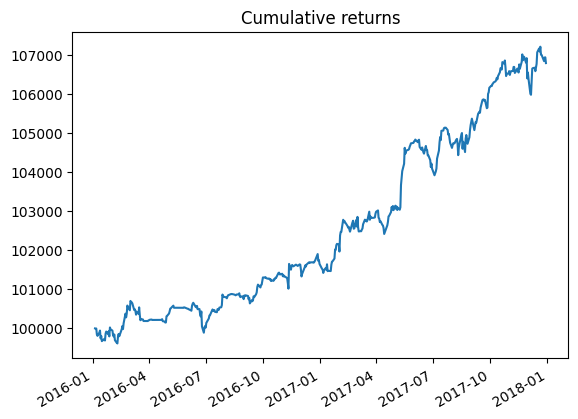

In [16]:
perf.portfolio_value.plot(title="Cumulative returns")

결과는 알고리즘의 누적 자산 가치를 보여주는 그래프입니다. 

일별 수익률의 히스토그램 생성:
 
수익률 히스토그램 그리기

<Axes: >

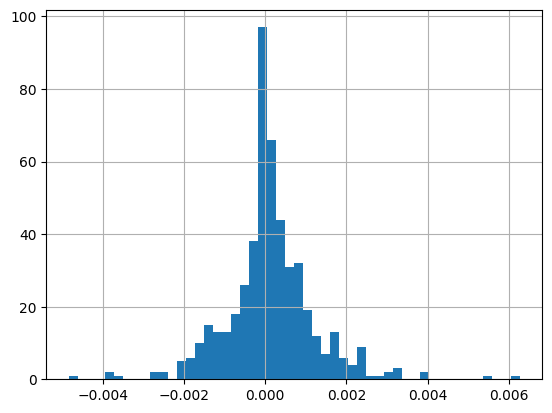

In [17]:
perf.returns.hist(bins=50)

결과는 50개의 구간으로 나눈 일별 수익률의 빈도를 보여주는 히스토그램입니다:

알고리즘의 롤링 샤프 비율 그래프 그리기:
 
샤프 비율 그래프 그리기

<Axes: >

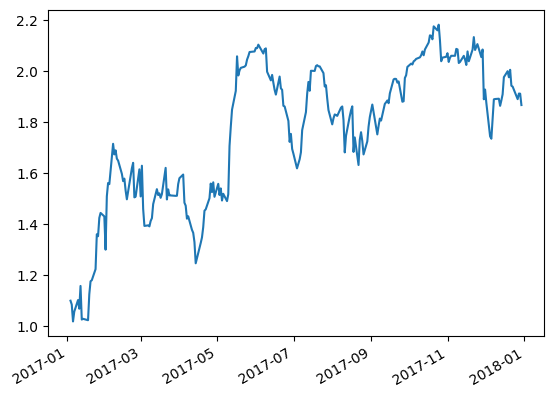

In [18]:
perf.sharpe.iloc[252:].plot()

결과는 알고리즘의 롤링 샤프 비율을 시각화한 그래프입니다:

>힌트
>
>결과는 pandas DataFrame이므로, 지금까지 배운 모든 데이터 조작 방법을 적용할 수 있습니다.

다음은 이미지에 포함된 텍스트를 한국어로 번역한 내용입니다:

---

### 추가 자료

Zipline Reloaded는 광범위한 기능을 사용하는 데 필요한 강력한 문서를 제공합니다. 아래에서 확인할 수 있습니다:

- **Zipline Reloaded 문서**: [https://zipline.ml4trading.io](https://zipline.ml4trading.io)  
- **프리미엄 미국 주식 데이터를 Zipline Reloaded에 삽입하는 방법을 설명하는 기사**: [https://www.pyquantnews.com/free-python-resources/how-to-ingest-premium-market-data-with-zipline-reloaded](https://www.pyquantnews.com/free-python-resources/how-to-ingest-premium-market-data-with-zipline-reloaded)

---

## **Zipline Reloaded를 사용한 평균 복귀 전략 탐구**

평균 복귀 전략은 자산 가격과 수익률이 괴리나 편차의 기간 후에 장기 평균 또는 평균 수준으로 결국 되돌아간다는 금융 원칙에 기반을 둡니다. 이러한 전략은 가격이 역사적 평균 또는 어떤 형태의 균형으로 돌아갈 것이라는 가정 하에 작동합니다. 이는 반응이나 기타 단기 요인으로 인해 균형에서 멀어질 경우 발생할 수 있습니다. 평균 복귀는 자산이 고유하고 안정적인 균형 상태에 있음을 시사합니다. 가격이 거래 감정, 뉴스, 이벤트와 같은 요인으로 인해 이 균형에서 크게 벗어날 경우, 시간이 지남에 따라 역사적 평균 가격 또는 다른 기준으로 돌아갈 가능성이 높습니다. 이러한 편차는 **z-점수**, **볼린저 밴드**, 또는 백분율 편차와 같은 다양한 지표를 사용하여 측정할 수 있습니다.

이 레시피에서는 **z-점수**를 사용합니다.

이 레시피에서는 Zipline Reloaded 팩터 프레임워크를 사용하여 포트폴리오를 구축할 것입니다. 이 전략은 가장 많이 과매도된 주식을 매수하고 가장 많이 과매수된 주식을 매도합니다.

---

### **준비 단계**

이 레시피의 대부분은 모멘텀 팩터를 시연하는 레시피와 동일하지만, 다음과 같은 몇 가지 차이점이 있습니다:

- 평균 복귀를 측정하고 상위 및 하위 평균 복귀 자산에 따라 유니버스를 순위화하도록 팩터를 업데이트했습니다.
- 백테스트의 현실감을 높이기 위해 수수료 및 슬리피지 규칙을 추가했습니다.
- 알고리즘 실행 중 피드백을 제공하고 사용할 수 있는 포트폴리오 속성을 표시하기 위해 간단한 로깅을 추가했습니다.
- 벤치마크 가격 데이터를 다운로드하고 알고리즘과의 비교를 위해 수익률을 포함했습니다.
- 백테스트가 완료될 때 실행되는 사용자 정의 함수를 포함했습니다.
- 유니버스 내 주식에 대한 로직을 보여주는 파이프라인 이미지를 생성했습니다.

라이브러리를 이미 가져왔다고 가정하며, 해당 단계는 건너뜁니다.

---

In [19]:
import warnings

In [20]:
import numpy as np
import pandas as pd
import pandas_datareader as web
from IPython.display import Markdown, display
from zipline import run_algorithm
from zipline.api import (
    attach_pipeline,
    calendars,
    date_rules,
    get_datetime,
    get_open_orders,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
    set_commission,
    set_slippage,
    time_rules,
)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume, CustomFactor, Returns

In [21]:
warnings.filterwarnings("ignore")

### **실행 방법...**

이전 레시피를 확장하여 분석에 복잡성을 추가합니다:

1. **longs**와 **shorts**의 수와 회귀 기간을 설정합니다:

In [22]:
N_LONGS = N_SHORTS = 50
MONTH = 21
YEAR = 12 * MONTH

2. 평균 복귀 팩터를 생성합니다:

사용자 정의 평균 회귀 팩터 정의

In [23]:
# 평균 회귀 팩터를 정의하는 클래스
class MeanReversion(CustomFactor):
    # 입력값으로 한 달(MONTH) 기간의 수익률 사용
    inputs = [Returns(window_length=MONTH)]
    # 1년(YEAR) 기간의 데이터를 사용
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        # 월별 수익률을 데이터프레임으로 변환
        df = pd.DataFrame(monthly_returns)
        # 최근 수익률에서 평균을 빼고 표준편차로 나누어 표준화
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())

3. 팩터를 사용하여 파이프라인을 반환하는 함수를 구현합니다:

팩터와 종목 선택을 위한 파이프라인 정의

In [24]:
def make_pipeline():
    # 평균 회귀 팩터 인스턴스 생성
    mean_reversion = MeanReversion()
    # 30일 평균 거래대금 팩터 생성
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(
        columns={
            # 평균 회귀가 가장 낮은 N_LONGS개 종목 선택 (매수 후보)
            "longs": mean_reversion.bottom(N_LONGS),
            # 평균 회귀가 가장 높은 N_SHORTS개 종목 선택 (매도 후보) 
            "shorts": mean_reversion.top(N_SHORTS),
            # 평균 회귀 순위 계산 (내림차순)
            "ranking": mean_reversion.rank(ascending=False),
        },
        # 거래대금 상위 100개 종목으로 유니버스 제한
        screen=dollar_volume.top(100),
    )

4. 거래 시작 전에 실행되는 이벤트에 연결되는 함수를 구현합니다:

거래 시작 전에 호출되는 함수를 정의합니다

In [25]:
def before_trading_start(context, data):
    """
    거래 시작 전에 호출되는 함수입니다.
    파이프라인의 결과를 context.factor_data에 저장합니다.
    
    Parameters
    ----------
    context : TradingAlgorithm
        알고리즘의 현재 상태를 포함하는 context 객체
    data : DataPortal
        현재 거래일의 시장 데이터에 접근하기 위한 객체
    """
    context.factor_data = pipeline_output("factor_pipeline")

5. 백테스트가 시작될 때 호출되는 함수를 구현합니다. 여기에는 수수료 및 슬리피지 모델 추가를 참고하세요:

알고리즘 설정을 위한 초기화 함수를 정의합니다

In [26]:
def initialize(context):
    # 팩터 파이프라인 연결
    attach_pipeline(make_pipeline(), "factor_pipeline")
    
    # 매주 시작일 장 시작시에 리밸런싱 함수 실행 스케줄링
    schedule_function(
        rebalance,
        date_rules.week_start(),
        time_rules.market_open(), 
        calendar=calendars.US_EQUITIES,
    )

    # 거래 수수료 설정 (주당 $0.00075, 최소 $0.01)
    set_commission(us_equities=commission.PerShare(cost=0.00075, min_trade_cost=0.01))

    # 슬리피지 모델 설정 (거래량 제한 0.25%, 가격 영향 1%)
    set_slippage(
        us_equities=slippage.VolumeShareSlippage(volume_limit=0.0025, price_impact=0.01)
    )

6. 이전 레시피에서 만든 **rebalance** 함수에 **print** 문을 추가합니다. 이 **print** 문은 알고리즘이 실행되는 동안 피드백을 제공합니다:

거래를 실행하는 리밸런싱 함수를 정의합니다

```python
def rebalance(context, data):
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)
```

7. **rebalance** 함수의 다음 섹션에서 **factor_data** DataFrame에서 심볼을 추출하고 자산 가격을 기록합니다:

```python
assets = factor_data.index
record(prices=data.current(assets, "price"))
```

8. 이제 포트폴리오에서 매수할 자산, 매도할 자산, 그리고 포트폴리오에서 제외할 자산을 식별합니다:

```python
longs = assets[factor_data.longs]
shorts = assets[factor_data.shorts]
divest = set(
    context.portfolio.positions.keys()) - set(
    longs.union(shorts))
```

9. 마지막으로 사용자에게 출력을 표시하고, **exec_trades** 함수를 사용하여 원하는 주문을 실행합니다:

```python
print(
    f"[{get_datetime().date()}] | Longs | {len(longs)} | Shorts | {len(shorts)} | {context.portfolio.portfolio_value}"
)
exec_trades(
    data,
    assets=divest,
    target_percent=0
)
exec_trades(
    data,
    assets=longs,
    target_percent=1 / N_LONGS
)
exec_trades(
    data,
    assets=shorts,
    target_percent=-1 / N_SHORTS
)
```

In [27]:
def rebalance(context, data):
    # 팩터 데이터 가져오기
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)

    # 자산 목록과 가격 데이터 기록
    assets = factor_data.index
    record(prices=data.current(assets, "price"))

    # 롱/숏 포지션 자산 식별
    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    # 청산할 포지션 찾기 (현재 포지션에서 롱/숏 제외)
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))
    
    # 현재 상태 출력
    print(
        f"{get_datetime().date()} | Longs {len(longs)} | Shorts | {len(shorts)} | {context.portfolio.portfolio_value}"
    )

    # 포지션 조정 실행
    exec_trades(data, assets=divest, target_percent=0)  # 청산
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)  # 롱 포지션
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS)  # 숏 포지션

10. 이전 레시피에서와 동일한 **exec_trades** 함수를 구현합니다:

거래를 실행하는 함수 정의

In [28]:
def exec_trades(data, assets, target_percent):
    """
    주어진 자산들에 대해 목표 비중으로 거래를 실행하는 함수
    
    Parameters
    ----------
    data : 현재 시장 데이터
    assets : 거래할 자산 목록
    target_percent : 각 자산의 목표 비중 (롱: 양수, 숏: 음수)
    """
    for asset in assets:
        # 거래 가능하고 미체결 주문이 없는 자산에 대해서만 주문 실행
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

11. 백테스트가 완료된 후 **analyze** 함수가 실행됩니다. 이 함수는 **context** 객체와 **perf** DataFrame에 액세스할 수 있습니다. 이는 특정 임계값이 초과될 경우 보고서 실행 또는 이벤트 트리거 경고에 유용합니다. 이 예제에서는 단순히 포트폴리오 가치를 플로팅합니다:

성과를 플로팅하는 analyze 함수 정의

In [29]:
def analyze(context, perf):
    perf.portfolio_value.plot()

12. **pandas.datareader**를 사용하여 벤치마크의 일일 수익률을 계산합니다. 여기서는 S&P 500 지수를 사용합니다:

백테스트의 시작일과 종료일 정의

In [30]:
start = pd.Timestamp("2016")
end = pd.Timestamp("2018")

벤치마크 수익률 가져오기 (S&P 500)

In [31]:
sp500 = web.DataReader("SP500", "fred", start, end).SP500
benchmark_returns = sp500.pct_change()

13. 마지막으로, 백테스트를 실행하고 출력을 캐시합니다:

Run the algorithm

백테스트가 실행되는 동안, 다음과 같은 출력이 나타날 것입니다:  
(예: 실행되는 로직이나 값의 예시)

14. 백테스트가 완료되면 analyze 함수가 호출되고 성과가 플로팅됩니다:

2016-01-04 | Longs 0 | Shorts | 1 | 100000.0
2016-01-11 | Longs 0 | Shorts | 1 | 99993.16349999886
2016-01-19 | Longs 2 | Shorts | 1 | 100021.36374999832
2016-01-25 | Longs 2 | Shorts | 2 | 100047.47224999769
2016-02-01 | Longs 3 | Shorts | 3 | 99889.9749999967
2016-02-08 | Longs 2 | Shorts | 2 | 99616.54649999554
2016-02-16 | Longs 2 | Shorts | 0 | 99849.90549999391
2016-02-22 | Longs 1 | Shorts | 0 | 100195.42449999285
2016-02-29 | Longs 1 | Shorts | 0 | 100155.76424999181
2016-03-07 | Longs 2 | Shorts | 1 | 100114.18424999181
2016-03-14 | Longs 0 | Shorts | 0 | 100304.28374999072
2016-03-21 | Longs 1 | Shorts | 2 | 99210.60974998782
2016-03-28 | Longs 1 | Shorts | 0 | 99355.18649998584
2016-04-04 | Longs 1 | Shorts | 0 | 99108.98424998432
2016-04-11 | Longs 2 | Shorts | 1 | 99483.63424998433
2016-04-18 | Longs 2 | Shorts | 0 | 99556.3877499843
2016-04-25 | Longs 2 | Shorts | 0 | 99573.0884999835
2016-05-02 | Longs 4 | Shorts | 0 | 99557.5844999825
2016-05-09 | Longs 3 | Shorts | 1 |

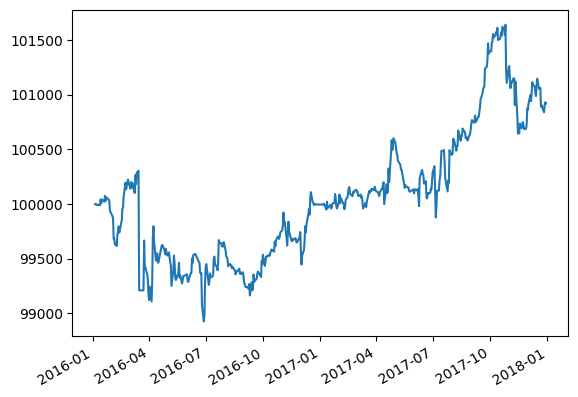

In [32]:
# 알고리즘 실행 및 성과 데이터 생성
# - start/end: 백테스트 기간 설정
# - initialize: 초기 설정 함수
# - analyze: 결과 분석 함수
# - benchmark_returns: 벤치마크 수익률
# - before_trading_start: 매 거래일 시작 전 실행되는 함수
# - capital_base: 초기 투자금액 (10만 달러)
# - bundle: 사용할 데이터 번들
perf = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    analyze=analyze,
    benchmark_returns=benchmark_returns,
    before_trading_start=before_trading_start,
    capital_base=100_000,
    bundle="quandl",
)

# 성과 데이터를 피클 파일로 저장
perf.to_pickle("mean_reversion.pickle")

>**중요 사항**  
>
>눈치 빠른 독자는 마치 버그처럼 보일 수 있는 현상을 발견할 수 있습니다: 왜 몇몇 주식에 대해서만 **long** 또는 **short** 포지션을 취하는지, 반면 **longs**와 **shorts**의 수를 50으로 설정했는지에 대한 의문이 있을 수 있습니다. 이에 대한 답은 **Pipeline** 클래스가 필터를 처리하는 순서에 있습니다. 우리는 **dollar_volume** 팩터에 연결된 **screen** 인수를 포함했습니다. 이 필터는 **long** 및 **short** 선택이 이루어진 후 작동하며, $100,000 이상의 달러 거래량을 가진 주식만을 표시합니다. 만약 이 필터링 기준을 제거한다면, 로그는 예상대로 50개의 **longs**와 50개의 **shorts**를 표시할 것입니다.

### 작동 방식...

우리의 사용자 정의 팩터는 **Returns** 클래스를 사용하여 월 단위로 설정된 창 길이를 사용하며, 이는 고정된 **MONTH**를 나타냅니다. 팩터의 전체 창 길이는 고정된 **YEAR**로 설정됩니다. **compute** 메서드 내에서 월별 수익률은 **DataFrame**으로 변환됩니다. 자산별 팩터 값은 지난달 수익률에서 모든 월별 수익률의 평균을 뺀 뒤, 해당 수익률의 표준 편차로 나누는 방식으로 계산됩니다. 이는 Z-점수와 유사한 측정값을 생성하며, 각 자산의 평균 복귀 경향성을 나타냅니다.

**make_pipeline** 함수는 이전 레시피에서 생성한 것과 유사하지만, 평균 복귀 팩터를 사용한다는 점에서 차이가 있습니다. 함수 내에서는 **MeanReversion** 팩터의 인스턴스가 생성되며, 이는 각 자산의 평균 복귀 점수를 계산합니다. 또한, 유동성 필터링을 위해 30일 동안의 평균 달러 거래량을 계산하는 **AverageDollarVolume** 클래스도 사용됩니다. 함수의 핵심은 **Pipeline** 객체로, 이는 다음 세 가지 열을 생성하도록 설정됩니다:

- **longs**: 평균 복귀 점수가 가장 낮은 자산(가장 저평가된 자산)을 식별합니다.
- **shorts**: 평균 복귀 점수가 가장 높은 자산(가장 고평가된 자산)을 지정합니다.
- **ranking**: 평균 복귀 점수를 기준으로 각 자산의 순위를 내림차순으로 제공합니다.

파이프라인이 유동성 있는 자산에 중점을 두도록, 평균 달러 거래량 기준 상위 100개 자산만 고려하는 필터가 적용됩니다.

**initialize** 함수에서는 이전 레시피와 동일한 방식으로 파이프라인을 연결하고 리밸런싱을 예약합니다. 그러나 이번 구현에서는 수수료 및 슬리피지 모델을 포함합니다. **set_commission** 함수는 미국 주식의 경우 주당 비용으로 수수료 모델을 구성합니다. 구체적으로, 각 거래 주식당 $0.00075의 비용이 부과되며, 최소 거래 비용은 $0.01로 설정됩니다. 이를 통해 소규모 거래도 명목상의 비용이 부과되도록 보장합니다. **set_commission** 함수는 주문 크기와 주식의 평균 거래량의 관계를 기반으로 주가에 미치는 영향을 시뮬레이션하는 **VolumeShareSlippage** 메서드를 사용하여 슬리피지 모델을 설정합니다.

마지막으로, 벤치마크와 알고리즘 결과를 비교하기 위해 S&P 500 지수의 일일 수익률을 계산합니다.

---


### 추가 내용...

우리의 파이프라인은 간단합니다: 평균 복귀 팩터를 생성하고 $100,000 이상의 달러 거래량을 가진 상위 및 하위 주식을 선택한 후 결과를 반환합니다. Zipline Reloaded는 여러 팩터가 결합된 복합 팩터 모델을 지원하며, 이러한 경우 파이프라인의 구성을 시각화하는 것이 유용합니다.

다행히도, 파이프라인이 구성되는 방식을 설명하는 그림을 생성할 수 있습니다:

파이프라인 그래프 표시

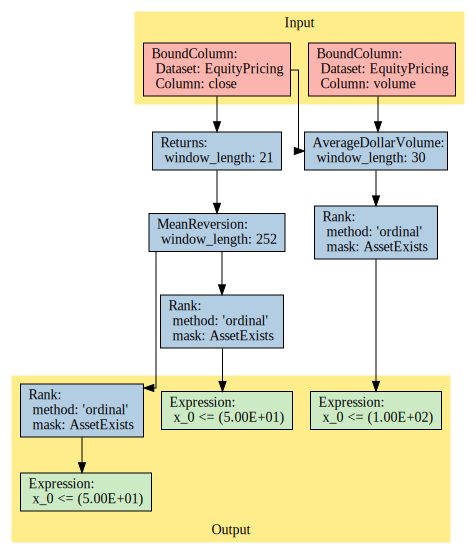

In [33]:
p = make_pipeline()
p.show_graph()

결과는 파이프라인의 시각적 묘사입니다.

Zipline Reloaded는 벤치마크 수익률을 포함함으로써 우리 포트폴리오의 롤링 알파와 베타를 벤치마크 대비 계산합니다. 이전 장에서 우리는 베타를 헤지하고 알파를 증폭시키는 방법을 배웠습니다. 백테스트의 결과를 사용하여 이러한 지표들을 활용할 수 있습니다.

벤치마크 대비 롤링 베타를 플롯합니다:

포트폴리오의 베타와 알파를 플롯

<Axes: >

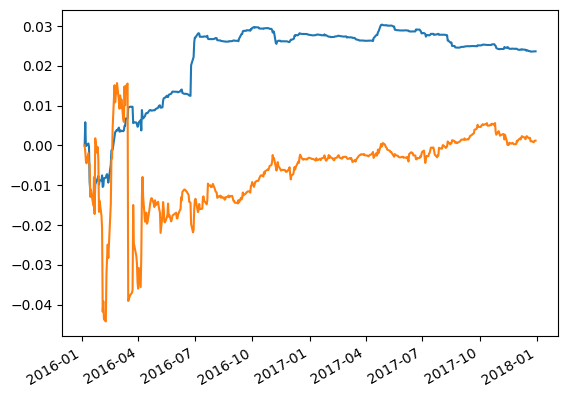

In [34]:
perf.beta.plot()
perf.alpha.plot()

벤치마크 대비 롤링 알파를 플롯합니다:

<Axes: >

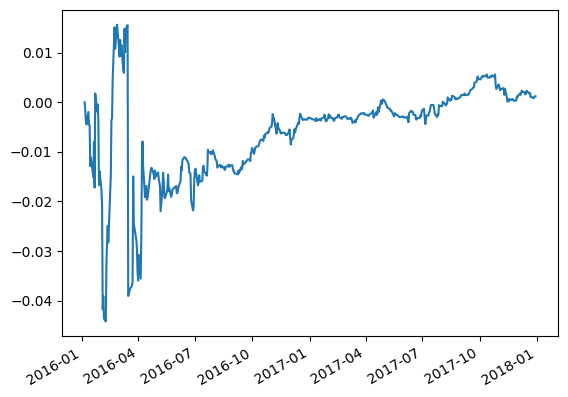

In [35]:
perf.alpha.plot()

---

### 추가 자료

우리는 Zipline Reloaded의 몇 가지 고급 기능을 더 깊이 탐구했습니다. 이러한 기능은 알고리즘 트레이더가 매일 직면하는 시장 역학을 보다 현실적으로 시뮬레이션하는 것을 목표로 합니다. 더 자세히 알아보려면 아래에 나열된 문서를 확인하세요:

- **Pipeline API의 API 문서**, 사용 가능한 입력 매개변수를 설명합니다:  
  [https://zipline.ml4trading.io/api-reference.html#pipeline-api](https://zipline.ml4trading.io/api-reference.html#pipeline-api)

- **Zipline Reloaded에서 사용 가능한 다양한 기본 제공 슬리피지 모델**:  
  [https://zipline.ml4trading.io/api-reference.html#slippage-models](https://zipline.ml4trading.io/api-reference.html#slippage-models)

- **Zipline Reloaded에서 사용 가능한 다양한 기본 제공 커미션 모델**:  
  [https://zipline.ml4trading.io/api-reference.html#commission-models](https://zipline.ml4trading.io/api-reference.html#commission-models)